In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Añadir la carpeta raíz del proyecto al PATH (ajústalo según donde esté tu notebook)
sys.path.append(os.path.abspath('..'))  # '..' significa que sube un nivel desde donde está el notebook

from utils.data_training_utils import train_test_model_with_hyperparameter_tuning, train_final_model_for_production


In [2]:
df = pd.read_csv("../data/working_data/data_cleaned_20250901.csv")

In [3]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7526 entries, 0 to 7525
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   price            7526 non-null   int64   
 1   propertyType     7526 non-null   category
 2   operation        7526 non-null   category
 3   size             7526 non-null   float64 
 4   rooms            7526 non-null   float64 
 5   bathrooms        7526 non-null   float64 
 6   municipality     7526 non-null   category
 7   district         7526 non-null   category
 8   neighborhood     7526 non-null   category
 9   latitude         7526 non-null   float64 
 10  longitude        7526 non-null   float64 
 11  status           7526 non-null   category
 12  newDevelopment   7526 non-null   bool    
 13  priceByArea      7526 non-null   float64 
 14  detailedType     7526 non-null   category
 15  floor            7526 non-null   float64 
 16  hasLift          7526 non-null   int64   


In [5]:
from sklearn.preprocessing import LabelEncoder

df_numeric = df.copy()
encoders = {}

for col in df_numeric.select_dtypes(include="category").columns:
    le = LabelEncoder()
    df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))
    encoders[col] = le


### XGBoost Model for rental prices

Probamos a entrenar el modelo primero sin escalar los datos y luego lo repetidos con los datos escalados para ver si de verdad mejoran los resultados

In [6]:
# Cogemos los datos que estan limpios y con las con todas las columnas numericas
df_rent = df[df['operation'] == 'rent']
df_rent

,price,propertyType,operation,size,rooms,bathrooms,municipality,district,neighborhood,latitude,longitude,status,newDevelopment,priceByArea,detailedType,floor,hasLift,hasParkingSpace
0,1500,flat,rent,95.0,2.0,2.0,Málaga,Centro,Perchel norte,36.721475,-4.430273,good,False,16.0,flat,3.0,0,False
1,1000,flat,rent,30.0,1.0,1.0,Málaga,Centro,Centro Histórico,36.720219,-4.422324,good,False,33.0,flat,4.0,0,False
2,1200,flat,rent,100.0,3.0,1.0,Málaga,Centro,La Trinidad,36.722701,-4.431447,good,False,12.0,flat,2.0,0,False
3,2000,flat,rent,140.0,3.0,2.0,Málaga,Centro,Centro Histórico,36.724211,-4.417712,good,False,14.0,flat,2.0,0,False
4,1300,flat,rent,75.0,2.0,1.0,Málaga,Centro,Cristo de la Epidemia,36.729643,-4.415604,good,False,17.0,flat,3.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,2200,flat,rent,120.0,4.0,2.0,Málaga,Teatinos,El Consul - El Romeral,36.726551,-4.475203,good,False,18.0,flat,2.0,0,True
3724,3500,flat,rent,100.0,2.0,2.0,Benahavís,La Quinta,El Hierro Alto,36.512106,-4.993355,good,False,35.0,flat,1.0,0,True
3725,2500,flat,rent,130.0,2.0,2.0,Marbella,Marbella Pueblo,Ricardo Soriano,36.511505,-4.893688,good,False,19.0,flat,6.0,0,False
3726,1400,flat,rent,45.0,1.0,1.0,Marbella,Nagüeles-Milla de Oro,La Carolina-Guadalpín,36.508736,-4.913561,good,False,31.0,flat,2.0,0,True


In [7]:
# Parámetros a probar (rango medio, no extremo)
param_grid = {
    'n_estimators': [100, 200, 300],          # Número de árboles
    'max_depth': [3, 5, 7],                   # Profundidad del árbol
    'learning_rate': [0.05, 0.1, 0.2],        # Tamaño de paso
    'subsample': [0.8, 1.0],                  # Proporción de datos para cada árbol
    'colsample_bytree': [0.8, 1.0]            # Proporción de features para cada árbol
}

# Modelo base
model = XGBRegressor(random_state=42, objective='reg:squarederror', verbosity=0, enable_categorical=True)

In [8]:
best_model, best_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_rent, drop_features=['operation'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best model found: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best training MAE: 280.5609375
Best training R2: 

In [9]:
df_numeric_rent = df_numeric[df_numeric['operation'] == 0]

best_rent_num_model, best_rent_num_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_numeric_rent, drop_features=['operation'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best model found: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best training MAE: 204.93349914550782
Best training R2: 0.9394517779350281
·····································

In [10]:
final_rent_model, model_path = train_final_model_for_production(
    best_rent_num_model, df_numeric_rent, target="price", drop_features=['operation'], model_dir="../models")

·········································
Final XGBRegressor trained with ALL data ✅
MAE (on full data): 181.0049
R2  (on full data): 0.9561
Model saved to: ../models\XGBRegressor_production_202509051628.joblib


<Figure size 1000x800 with 0 Axes>

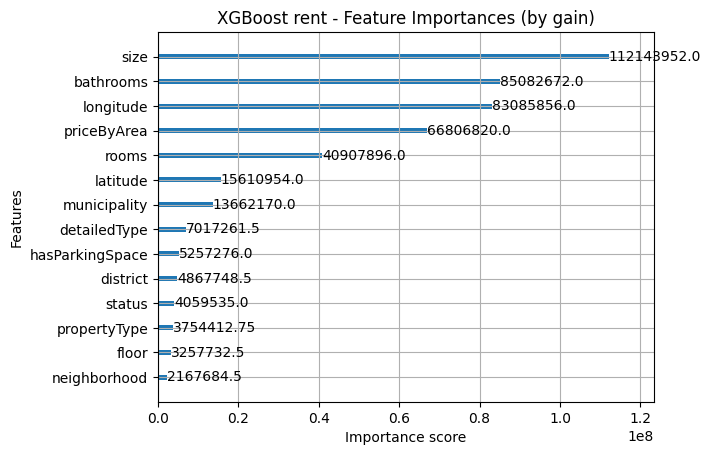

In [11]:
plt.figure(figsize=(10, 8))
plot_importance(final_rent_model, importance_type="gain")
plt.title("XGBoost rent - Feature Importances (by gain)")
plt.show()


### XGBoost Model for sale prices

In [12]:
df_sale = df[ df['operation'] == 'sale']
df_sale

,price,propertyType,operation,size,rooms,bathrooms,municipality,district,neighborhood,latitude,longitude,status,newDevelopment,priceByArea,detailedType,floor,hasLift,hasParkingSpace
3728,985000,chalet,sale,245.0,4.0,3.0,Málaga,Este,Parque Clavero,36.726046,-4.392859,good,False,4020.0,terracedHouse,0.0,0,True
3729,265000,flat,sale,66.0,2.0,1.0,Málaga,Carretera de Cádiz,Huelin,36.703176,-4.438555,good,False,4015.0,flat,8.0,1,False
3730,275000,flat,sale,82.0,2.0,2.0,Málaga,Centro,Olletas - Sierra Blanquilla,36.731530,-4.414621,good,False,3354.0,flat,1.0,0,False
3731,1600000,flat,sale,174.0,3.0,2.0,Málaga,Este,Malagueta - Monte Sancha,36.721393,-4.405125,good,False,9195.0,flat,1.0,0,True
3732,550000,flat,sale,143.0,3.0,2.0,Málaga,Centro,Centro Histórico,36.720695,-4.421476,good,False,3846.0,flat,3.0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7521,1375000,chalet,sale,264.0,3.0,3.0,Marbella,Las Chapas-El Rosario,El Rosario-Ricmar,36.508129,-4.802938,good,False,5208.0,independantHouse,0.0,0,True
7522,539000,penthouse,sale,125.0,2.0,2.0,Estepona,Benamara - Atalaya,Atalaya-Isdabe,36.465595,-5.019476,good,False,4312.0,penthouse,2.0,0,False
7523,1295000,chalet,sale,204.0,3.0,2.0,Marbella,Elviria-Cabopino,Elviria,36.503238,-4.783551,good,False,6348.0,independantHouse,0.0,0,True
7524,2195000,chalet,sale,240.0,4.0,3.0,Marbella,Elviria-Cabopino,Elviria,36.499696,-4.783793,good,False,9146.0,independantHouse,0.0,0,True


In [13]:
best_sale_model, best_sale_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_sale, drop_features=['operation'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\Claudia\MasterBigData\TFM\Rental-prices-predicction\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model found: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best training MAE: 95880.4125
Best training R2: 0.9046903491020203
·········································
MAE

In [14]:
df_numeric_sale = df_numeric[df_numeric['operation'] == 1]

best_sale_num_model, best_sale_num_params, mae_train, r2_train, mae_test, r2_test = train_test_model_with_hyperparameter_tuning(
    model, param_grid, df_numeric_sale, drop_features=['operation'])

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best model found: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best training MAE: 72325.834375
Best training R2:

In [15]:
final_sale_model, model_path = train_final_model_for_production(
    best_sale_num_model, df_numeric_sale, target="price", drop_features=['operation'], model_dir="../models")

·········································
Final XGBRegressor trained with ALL data ✅
MAE (on full data): 63670.2891
R2  (on full data): 0.9644
Model saved to: ../models\XGBRegressor_production_202509051654.joblib


<Figure size 1000x800 with 0 Axes>

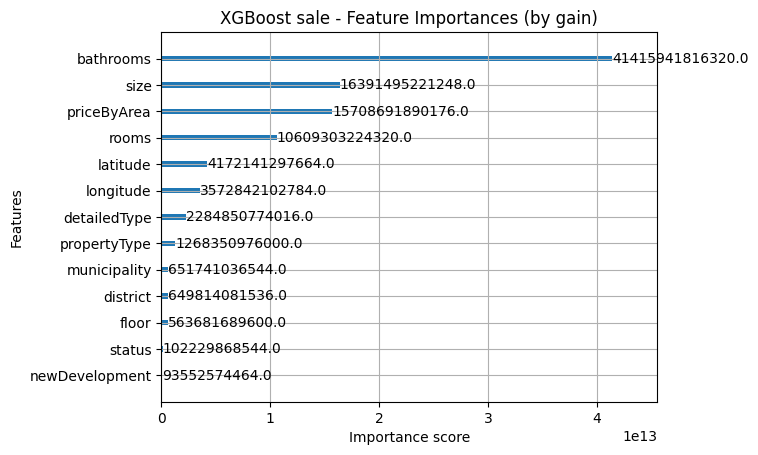

In [16]:
plt.figure(figsize=(10, 8))
plot_importance(final_sale_model, importance_type="gain")
plt.title("XGBoost sale - Feature Importances (by gain)")
plt.show()